# Log-Normal Mocks for DESI LRGs

In [1]:
!echo $HOME

/users/PHS0336/medirz90


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import fitsio as ft
import healpy as hp
from glob import glob
import sys

sys.path.append('/users/PHS0336/medirz90/github/LSSutils')
from lssutils.dataviz import setup_color
from lssutils.utils import histogram_cell, maps_dr9, make_hp, chi2_fn, get_chi2pdf, get_inv
from lssutils.stats.window import WindowSHT
from lssutils.io import read_nbmocks, read_nnbar, read_clx, read_clxmocks
from lssutils.theory.cell import (dNdz_model, init_sample, Spectrum)

In [3]:
setup_color()

## Power Spectra

In [37]:
nmocks = 100


cl_All = {}

for region in ['bmzls', 'ndecals', 'sdecals']:
    
    cl_all = {'noweight':[],
             'nn':[],
             'lin':[]}
    p = '/fs/ess/PHS0336/data/lognormal/v0/clustering/'

    for i in range(1, nmocks+1):

        for n in ['nn', 'lin', 'noweight']:
            cl_ = np.load(f'{p}clmock_{i}_lrg_{region}_256_{n}.npy', allow_pickle=True).item()
            cl_all[n].append(cl_['cl_gg']['cl'])
    print(f'{region} done')
    
    cl_All[region] = cl_all

bmzls done
ndecals done
sdecals done


[Text(0, 0.5, 'C$_{Null,X}$/C$_{Null}$')]

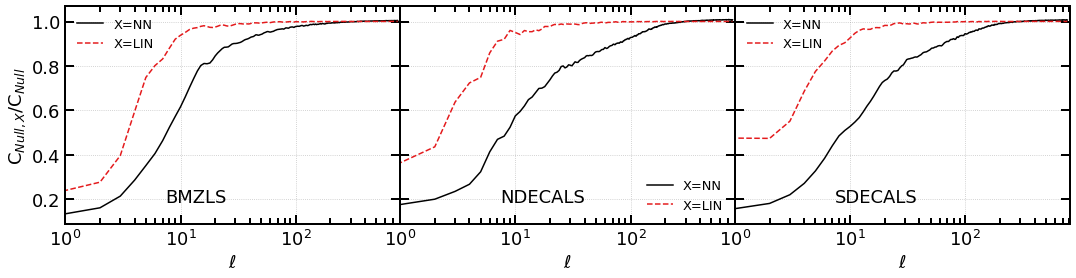

In [42]:
fg, ax_list = plt.subplots(ncols=3, figsize=(18, 4), sharey=True)
fg.subplots_adjust(wspace=0.0)

for i, (region, cl_all) in enumerate(cl_All.items()):
    
    ax = ax_list[i]
    null_mean = np.mean(cl_all['noweight'], axis=0)

    for n in ['nn', 'lin']:

        ax.plot(np.mean(cl_all[n], axis=0)/null_mean, label=f'X={n.upper()}')

    ax.text(0.3, 0.1, region.upper(), transform=ax.transAxes)
    #ax.set(xscale='log', yscale='log', 
    #       ylabel=r'C$_{\ell}$', xlabel='$\ell$', ylim=(1.0e-7, 1.0e-4))
    ax.set(xlim=(1, 805), xscale='log', xlabel=r'$\ell$')
    ax.legend()
    ax.grid(ls=':', color='grey', alpha=0.5)
    
ax_list[0].set(ylabel='C$_{Null,X}$/C$_{Null}$')
# ax.set_title('Mean of 100 Mocks')

In [10]:
cl_ = np.load(cell_list[0], allow_pickle=True).item()

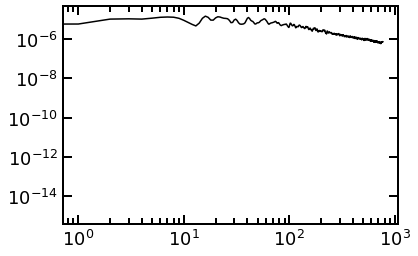

## Cross Power of Mocks

In [14]:
def make_cellchi2(region):      
    # region = 'bmzls'
    nmocks = 100
    _, err_nn, cl_ss = read_clx(f'/fs/ess/PHS0336/data/rongpu/imaging_sys/clustering/v2/cl_lrg_{region}_256_nn.npy')
    _, err_lin, _ = read_clx(f'/fs/ess/PHS0336/data/rongpu/imaging_sys/clustering/v2/cl_lrg_{region}_256_lin.npy', cl_ss)
    
    cell_list = [f'/fs/ess/PHS0336/data/lognormal/v0/clustering/clmock_{i}_lrg_{region}_256_noweight.npy'\
                for i in range(nmocks+1, 1001)]
    print(len(cell_list))
    
    cell_mocks = read_clxmocks(cell_list, cl_ss)  
    invcov, covmax = get_inv(cell_mocks, True)
    
    # read chi2 of mocks
    chi2s = {'noweight':[], 'nn':[], 'lin':[]}
    for i in range(1, nmocks+1):
        for n in ['nn', 'lin', 'noweight']:
            _,d_,_ = read_clx(f'/fs/ess/PHS0336/data/lognormal/v0/clustering/clmock_{i}_lrg_{region}_256_{n}.npy', cl_ss)
            chi_ = chi2_fn(d_, invcov)
            chi2s[n].append(chi_)
        
    chi2d = {}
    chi2d['nn'] = chi2_fn(err_nn, invcov)
    chi2d['lin'] = chi2_fn(err_lin, invcov)
    
    fg, ax = plt.subplots() # https://stackoverflow.com/a/25497638/9746916
    ax.scatter(chi2s['noweight'], chi2s['nn'], marker='.', color='r', alpha=0.5)
    ax.scatter(chi2s['noweight'], chi2s['lin'], marker='.', color='b', facecolor='w', alpha=0.5)
    ax.scatter(np.mean(chi2s['noweight']), chi2d['nn'], 300, color='r', marker='*')
    ax.scatter(np.mean(chi2s['noweight']), chi2d['lin'], 300, color='b', marker='o')    
    lims = [np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
            np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
           ]

    # now plot both limits against eachother
    ax.set_title(region.upper())
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    # ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    ax.set_xlabel(r'$\chi^{2}$ of Null Mocks')
    ax.set_ylabel(r'$\chi^{2}$ of Mitigated Null Mocks')
    fg.show()    

900
....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................Hartlap factor: 1.151088348271447
with nmocks: 900 and nbins: 117


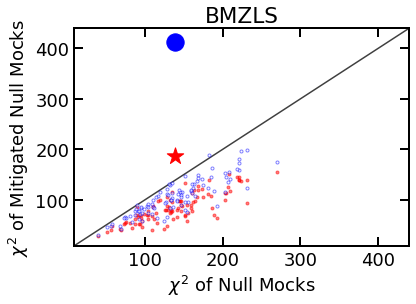

In [15]:
make_cellchi2('bmzls')

900
....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................Hartlap factor: 1.151088348271447
with nmocks: 900 and nbins: 117


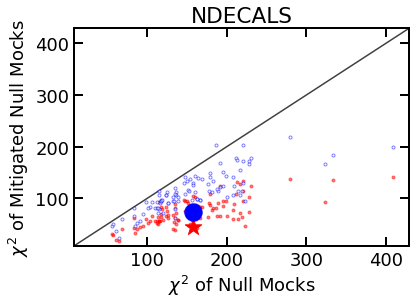

In [16]:
make_cellchi2('ndecals')

900
....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................Hartlap factor: 1.151088348271447
with nmocks: 900 and nbins: 117


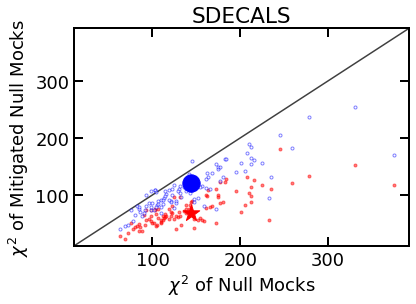

In [17]:
make_cellchi2('sdecals')

## Mean Density of Mocks

In [4]:
def make_nbarchi2(region):    
    # region = 'bmzls'
    nmocks = 100
    nbar_list = [f'/fs/ess/PHS0336/data/lognormal/v0/clustering/nbarmock_{i}_lrg_{region}_256_noweight.npy'\
                for i in range(nmocks+1, 1001)]
    print(len(nbar_list))
    nbar_mocks = read_nbmocks(nbar_list)

    invcov, covmax = get_inv(nbar_mocks, True)

    # fg, ax = plt.subplots(ncols=3, figsize=(12, 6), sharey=True)
    # fg.subplots_adjust(wspace=0.05, hspace=0.0)

    # map0 = ax[0].imshow(covmax, origin='lower', cmap=plt.cm.bwr)#, vmin=-2.0e-5, vmax=2.0e-5)
    # fg.colorbar(map0, ax=ax[0], orientation='horizontal',)# ticks=[-1.0e-5, 0, 1.0e-5], shrink=0.5)

    # map1 = ax[1].imshow(invcov, origin='lower', cmap=plt.cm.bwr)#, vmin=-2.0e6, vmax=2.0e6,)
    # fg.colorbar(map1, ax=ax[1], orientation='horizontal')#, shrink=0.5, ticks=[-1.0e6, 0, 1.0e6])


    # map2 = ax[2].imshow(covmax.dot(invcov), origin='lower', cmap=plt.cm.viridis)#, vmin=0, vmax=2.0)
    # fg.colorbar(map2, ax=ax[2], orientation='horizontal',)# ticks=[0., 1, 2.0], shrink=0.5)
    # plt.show()

    # read chi2 of mocks
    chi2s = {'noweight':[], 'nn':[], 'lin':[]}
    for i in range(1, nmocks+1):
        for n in ['noweight', 'nn', 'lin']:
            d_ = read_nnbar(f'/fs/ess/PHS0336/data/lognormal/v0/clustering/nbarmock_{i}_lrg_{region}_256_{n}.npy')
            chi_ = chi2_fn(d_, invcov)
            chi2s[n].append(chi_)

    nb_data = read_nnbar(f'/fs/ess/PHS0336/data/rongpu/imaging_sys/clustering/v2/nbar_lrg_{region}_256_nn.npy')
    chi2_data = chi2_fn(nb_data, invcov)

    nb_data_ = read_nnbar(f'/fs/ess/PHS0336/data/rongpu/imaging_sys/clustering/v2/nbar_lrg_{region}_256_lin.npy')
    chi2_data_ = chi2_fn(nb_data_, invcov)
    
    
    fg, ax = plt.subplots() # https://stackoverflow.com/a/25497638/9746916

    ax.scatter(chi2s['noweight'], chi2s['nn'], marker='.', color='r', alpha=0.5)
    ax.scatter(chi2s['noweight'], chi2s['lin'], marker='.', color='b', facecolor='w', alpha=0.5)
    ax.scatter(np.mean(chi2s['noweight']), chi2_data, 
               300, color='r', marker='*')
    #ax.axhline(chi2_data, ls='-', color='r', alpha=0.5)
    ax.scatter(np.mean(chi2s['noweight']), chi2_data_, 
              300, color='b', marker='o')
    #ax.axhline(chi2_data_, ls='--', color='b', alpha=0.5)
    
    lims = [np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
            np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
           ]

    # now plot both limits against eachother
    ax.set_title(region.upper())
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    # ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    ax.set_xlabel(r'$\chi^{2}$ of Null Mocks')
    ax.set_ylabel(r'$\chi^{2}$ of Mitigated Null Mocks')
    fg.show()
    
    fg, ax = plt.subplots() # https://stackoverflow.com/a/25497638/9746916

    ax.scatter(chi2s['noweight'], chi2s['nn'], marker='.', color='r', alpha=0.5)
    #ax.scatter(chi2s['noweight'], chi2s['lin'], marker='.', color='b', facecolor='w', alpha=0.5)
    ax.scatter(np.mean(chi2s['noweight']), chi2_data, 
               300, color='r', marker='*')
    #ax.axhline(chi2_data, ls='-', color='r', alpha=0.5)
    #ax.scatter(np.mean(chi2s['noweight']), chi2_data_, 
    #          300, color='b', marker='o')
    #ax.axhline(chi2_data_, ls='--', color='b', alpha=0.5)
    
    #lims = [np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    #        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    #       ]

    # now plot both limits against eachother
    ax.set_title(region.upper())
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    # ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    ax.set_xlabel(r'$\chi^{2}$ of Null Mocks')
    ax.set_ylabel(r'$\chi^{2}$ of Mitigated Null Mocks')    
    fg.show()
    
    
    fg, ax = plt.subplots() # https://stackoverflow.com/a/25497638/9746916

    ax.scatter(chi2s['noweight'], chi2s['nn'], marker='.', color='r', alpha=0.5)
    #ax.scatter(chi2s['noweight'], chi2s['lin'], marker='.', color='b', facecolor='w', alpha=0.5)
    #ax.scatter(np.mean(chi2s['noweight']), chi2_data, 
    #           300, color='r', marker='*')
    #ax.axhline(chi2_data, ls='-', color='r', alpha=0.5)
    #ax.scatter(np.mean(chi2s['noweight']), chi2_data_, 
    #          300, color='b', marker='o')
    #ax.axhline(chi2_data_, ls='--', color='b', alpha=0.5)
    
    #lims = [np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    #        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    #       ]

    # now plot both limits against eachother
    ax.set_title(region.upper())
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    # ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    ax.set_xlabel(r'$\chi^{2}$ of Null Mocks')
    ax.set_ylabel(r'$\chi^{2}$ of Mitigated Null Mocks')    
    fg.show()

900
....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................(900, 104)
Hartlap factor: 1.1322418136020151
with nmocks: 900 and nbins: 104


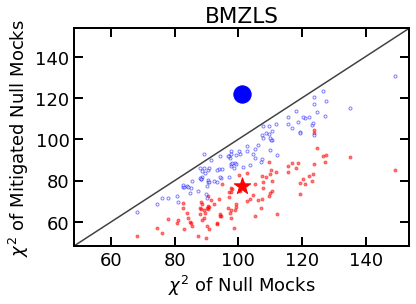

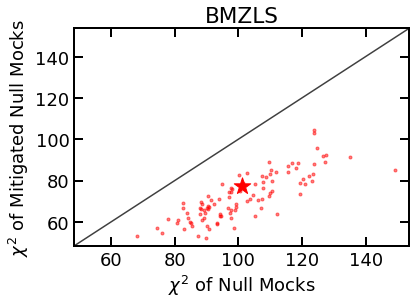

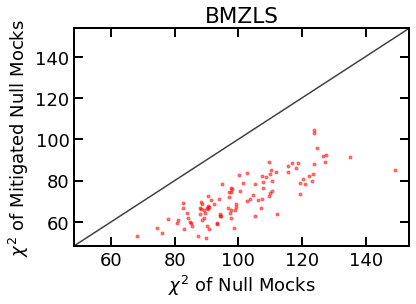

In [7]:
make_nbarchi2('bmzls')

900
....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................(900, 104)
Hartlap factor: 1.1322418136020151
with nmocks: 900 and nbins: 104


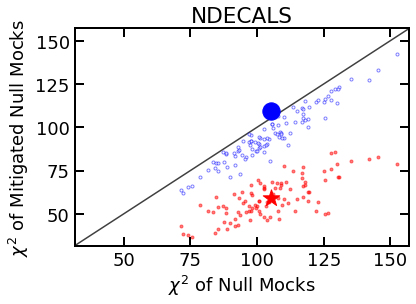

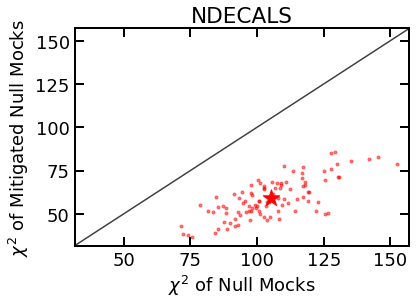

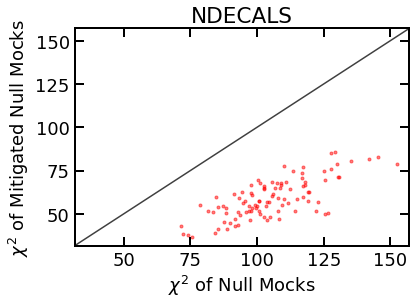

In [8]:
make_nbarchi2('ndecals')

900
....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................(900, 104)
Hartlap factor: 1.1322418136020151
with nmocks: 900 and nbins: 104


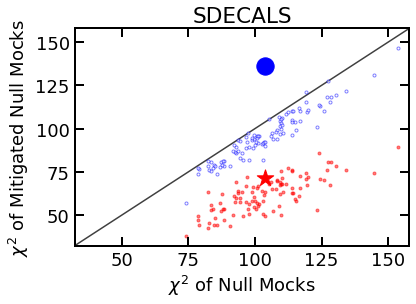

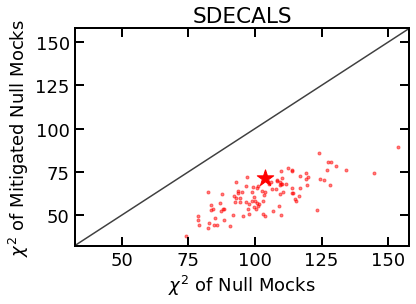

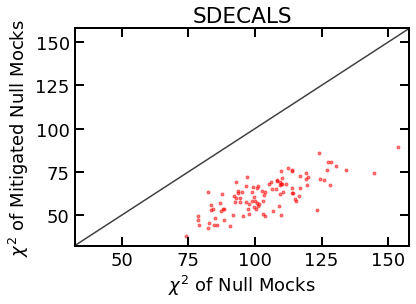

In [9]:
make_nbarchi2('sdecals')

In [4]:
region = 'bmzls'
nmocks = 100
nbar_list = [f'/fs/ess/PHS0336/data/lognormal/v0/clustering/nbarmock_{i}_lrg_{region}_256_noweight.npy'\
            for i in range(nmocks+1, 1001)]
print(len(nbar_list))
nbar_mocks = read_nbmocks(nbar_list)

invcov, covmax = get_inv(nbar_mocks, True)
err = np.sqrt(np.diag(covmax))

900
....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................(900, 104)
Hartlap factor: 1.1322418136020151
with nmocks: 900 and nbins: 104


In [5]:
nbars = {}
nbars['No Weight'] = np.load('/fs/ess/PHS0336/data/lognormal/v0/clustering/nbarmock_1_lrg_bmzls_256_noweight.npy', allow_pickle=True)
nbars['NN'] = np.load('/fs/ess/PHS0336/data/lognormal/v0/clustering/nbarmock_1_lrg_bmzls_256_nn.npy', allow_pickle=True)
nbars['Linear'] = np.load('/fs/ess/PHS0336/data/lognormal/v0/clustering/nbarmock_1_lrg_bmzls_256_lin.npy', allow_pickle=True)

(0.004, 0.16)

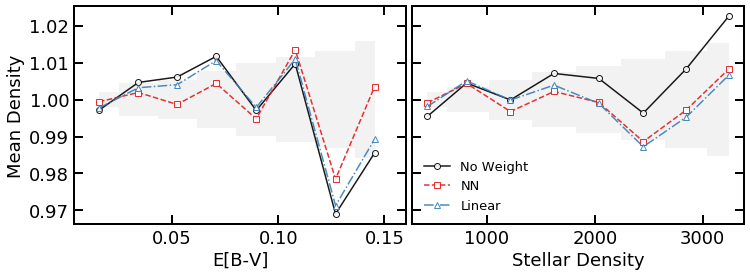

In [9]:
fg, ax = plt.subplots(ncols=2, figsize=(12, 4), sharey=True)
fg.subplots_adjust(wspace=0.02)

mk = ['o', 's', '^']
j = 0
for n_i, d_i in nbars.items():
    for i in [0, 1]:
        ax[i].plot(d_i[i]['bin_avg'], d_i[i]['nnbar'],
                    mfc='w', alpha=0.9, label=n_i, marker=mk[j])
        if j==0:
            ax[i].fill_between(d_i[i]['bin_avg'], 1-err[i*8:(i+1)*8], 1+err[i*8:(i+1)*8],
                               alpha=0.1, step='mid', fc='grey')#, ec='k', lw=2)     
            
    j += 1
    
ax[1].legend(loc='lower left')

for i, sys in enumerate(['E[B-V]', 'Stellar Density']):
    ax[i].set_xlabel(sys)
    
ax[0].set_ylabel('Mean Density')
ax[0].set_xlim(0.004, 0.16)

## The effect of the fNL and systematics

In [3]:
z, b, dNdz = init_sample(kind='lrg')

model = Spectrum()

ell = np.arange(3000)
model.add_tracer(z, b, dNdz, p=1.6)
model.make_kernels(ell)

h         : 0.67556
T0_cmb    : 2.7255
Omega0_b  : 0.0482754208891869
Omega0_cdm: 0.26377065934278865
N_ur      : None
m_ncdm    : [0.06]
P_k_max   : 10.0
P_z_max   : 100.0
sigma8    : 0.8225
gauge     : synchronous
n_s       : 0.9667
nonlinear : False
p = 1.6


In [4]:
# mask
dt = ft.read('/home/mehdi/data/rongpu/imaging_sys/tables/nlrg_features_bmzls_256.fits')
mask_ = make_hp(256, dt['hpix'], 1.0) > 0.5
mask = hp.ud_grade(mask_, 1024)
weight = mask * 1.0

In [5]:
noise = 5.247718593589074e-07
el_m = np.arange(2*1024)
wd = WindowSHT(weight, mask, el_m, ngauss=2*1024)

In [26]:
cl_true = {}
for fnl in [-40, 0, 20, 100, 200]:
    cl_ = model(ell, fnl=fnl)
    cl_true[fnl] = wd.convolve(np.arange(cl_.size), cl_)+noise
    print(fnl)

-40
0
20
100
200


In [10]:
cl_dr9 = np.load('/home/mehdi/data/rongpu/imaging_sys/clustering/v2/cl_lrg_bmzls_256_nn.npy', 
                allow_pickle=True).item()
cl_dr9n = np.load('/home/mehdi/data/rongpu/imaging_sys/clustering/v2/cl_lrg_bmzls_256_noweight.npy', 
                allow_pickle=True).item()

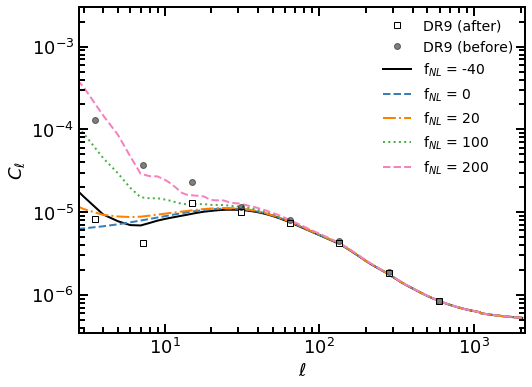

In [27]:
plt.figure(figsize=(8, 6))

plt.plot(*histogram_cell(cl_dr9['cl_gg']['cl'], bins=np.logspace(0, np.log10(769), 10)),
            marker='s', mfc='w', ls='None',
            color='k', label='DR9 (after)')
plt.plot(*histogram_cell(cl_dr9n['cl_gg']['cl'], bins=np.logspace(0, np.log10(769), 10)),
            marker='o', color='k', alpha=0.5, ls='None', label='DR9 (before)')



for fnl_, cl_ in cl_true.items():
    plt.plot(cl_, lw=2, label=r'f$_{NL}$ = %.0f'%fnl_, zorder=-10)
plt.legend(fontsize=14)
plt.xlim(xmin=2.8)
plt.yscale('log')
plt.ylabel(r'$C_{\ell}$')
plt.xlabel(r'$\ell$')
plt.xscale('log')
plt.savefig('fnl_cl.png', dpi=300, bbox_inches='tight')

## Cell Systematic Test

In [9]:
def make_chi2plot(region):
    #region = 'bmzls'
    print(f'region: {region}')

    l, err_0, cl_ss = read_clx(f'/home/mehdi/data/rongpu/imaging_sys/clustering/v2/cl_lrg_{region}_256_noweight.npy')
    _, err_1, __ = read_clx(f'/home/mehdi/data/rongpu/imaging_sys/clustering/v2/cl_lrg_{region}_256_nn.npy')

    list_cls = glob(f'/home/mehdi/data/lognormal/v0/clustering/clmock_*_lrg_{region}_256_noweight.npy')
    err_tot = read_clxmocks(list_cls, cl_ss)

    print('ell', l)
    print('# mocks', len(list_cls))
    invcov, covmax = get_inv(err_tot, True)

    chi2_mocks = get_chi2pdf(err_tot)
    chi2_before = chi2_fn(err_0, invcov)
    chi2_after = chi2_fn(err_1, invcov)

    print(chi2_before, chi2_after)
    plt.hist(chi2_mocks, alpha=0.2, label='Mocks (leave-one-out)')
    plt.axvline(chi2_before, alpha=0.5, ls='--', label='Data')
    plt.axvline(chi2_after, label='Data (cleaned)')
    plt.legend(title=region.upper())
    plt.xscale('symlog', linscalex=3, linthreshx=1000.)
    plt.xlabel(r'Cross Power $\chi^{2}$')
    plt.show()
    
#     fg, ax = plt.subplots(ncols=3, figsize=(12, 6), sharey=True)
#     fg.subplots_adjust(wspace=0.05, hspace=0.0)

#     map0 = ax[0].imshow(covmax, origin='lower', cmap=plt.cm.bwr)#, vmin=-2.0e-5, vmax=2.0e-5)
#     fg.colorbar(map0, ax=ax[0], orientation='horizontal',)# ticks=[-1.0e-5, 0, 1.0e-5], shrink=0.5)

#     map1 = ax[1].imshow(invcov, origin='lower', cmap=plt.cm.bwr)#, vmin=-2.0e6, vmax=2.0e6,)
#     fg.colorbar(map1, ax=ax[1], orientation='horizontal')#, shrink=0.5, ticks=[-1.0e6, 0, 1.0e6])


#     map2 = ax[2].imshow(covmax.dot(invcov), origin='lower', cmap=plt.cm.viridis)#, vmin=0, vmax=2.0)
#     fg.colorbar(map2, ax=ax[2], orientation='horizontal',)# ticks=[0., 1, 2.0], shrink=0.5)
#     plt.show()

region: bmzls
..........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

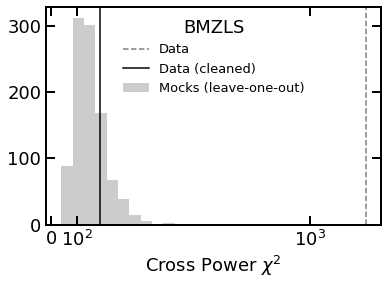

region: ndecals
........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

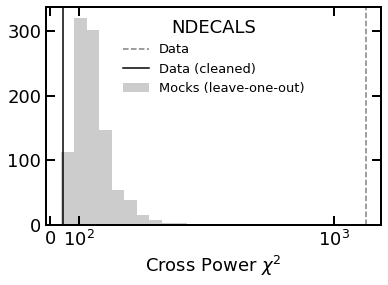

region: sdecals
........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

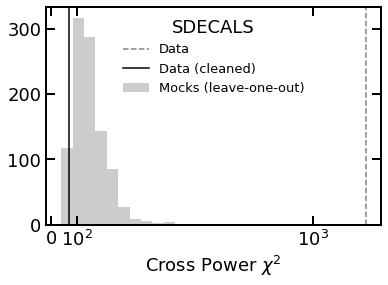

In [10]:
for reg in ['bmzls', 'ndecals', 'sdecals']:
    make_chi2plot(reg)

In [104]:
from matplotlib.ticker import Locator, SymmetricalLogLocator


class MajorSymLogLocator(SymmetricalLogLocator):

    def __init__(self, base=10., linthresh=1.0):
        super().__init__(base=base, linthresh=linthresh)

    @staticmethod
    def orders_magnitude(vmin, vmax):

        max_size = np.log10(max(abs(vmax), 1))
        min_size = np.log10(max(abs(vmin), 1))

        if vmax > 1 and vmin > 1:
            return max_size - min_size
        elif vmax < -1 and vmin < -1:
            return min_size - max_size
        else:
            return max(min_size, max_size)

    def tick_values(self, vmin, vmax):

        if vmax < vmin:
            vmin, vmax = vmax, vmin

        orders_magnitude = self.orders_magnitude(vmin, vmax)

        if orders_magnitude <= 1:
            spread = vmax - vmin
            exp = np.floor(np.log10(spread))
            rest = spread * 10 ** (-exp)

            stride = 10 ** exp * (0.25 if rest < 2. else
                                  0.5 if rest < 4 else
                                  1. if rest < 6 else
                                  2.)

            vmin = np.floor(vmin / stride) * stride
            return np.arange(vmin, vmax, stride)

        if orders_magnitude <= 2:
            pos_a, pos_b = np.floor(np.log10(max(vmin, 1))), np.ceil(np.log10(max(vmax, 1)))
            positive_powers = 10 ** np.linspace(pos_a, pos_b, int(pos_b - pos_a) + 1)
            positive = np.ravel(np.outer(positive_powers, [1., 5.]))

            linear = np.array([0.]) if vmin < 1 and vmax > -1 else np.array([])

            neg_a, neg_b = np.floor(np.log10(-min(vmin, -1))), np.ceil(np.log10(-min(vmax, -1)))
            negative_powers = - 10 ** np.linspace(neg_b, neg_a, int(neg_a - neg_b) + 1)[::-1]
            negative = np.ravel(np.outer(negative_powers, [1., 5.]))

            return np.concatenate([negative, linear, positive])

        else:

            pos_a, pos_b = np.floor(np.log10(max(vmin, 1))), np.ceil(np.log10(max(vmax, 1)))
            positive = 10 ** np.linspace(pos_a, pos_b, int(pos_b - pos_a) + 1)

            linear = np.array([0.]) if vmin < 1 and vmax > -1 else np.array([])

            neg_a, neg_b = np.floor(np.log10(-min(vmin, -1))), np.ceil(np.log10(-min(vmax, -1)))
            negative = - 10 ** np.linspace(neg_b, neg_a, int(neg_a - neg_b) + 1)[::-1]

            return np.concatenate([negative, linear, positive])

def symlogfmt(x, pos):
    return f'{x:.6f}'.rstrip('0')


class MinorSymLogLocator(Locator):
    """
    Dynamically find minor tick positions based on the positions of
    major ticks for a symlog scaling.
    """
    def __init__(self, linthresh, nints=10):
        """
        Ticks will be placed between the major ticks.
        The placement is linear for x between -linthresh and linthresh,
        otherwise its logarithmically. nints gives the number of
        intervals that will be bounded by the minor ticks.
        """
        self.linthresh = linthresh
        self.nintervals = nints

    def __call__(self):
        # Return the locations of the ticks
        majorlocs = self.axis.get_majorticklocs()

        if len(majorlocs) == 1:
            return self.raise_if_exceeds(np.array([]))

        # add temporary major tick locs at either end of the current range
        # to fill in minor tick gaps
        dmlower = majorlocs[1] - majorlocs[0]    # major tick difference at lower end
        dmupper = majorlocs[-1] - majorlocs[-2]  # major tick difference at upper end

        # add temporary major tick location at the lower end
        if majorlocs[0] != 0. and ((majorlocs[0] != self.linthresh and dmlower > self.linthresh) or (dmlower == self.linthresh and majorlocs[0] < 0)):
            majorlocs = np.insert(majorlocs, 0, majorlocs[0]*10.)
        else:
            majorlocs = np.insert(majorlocs, 0, majorlocs[0]-self.linthresh)

        # add temporary major tick location at the upper end
        if majorlocs[-1] != 0. and ((np.abs(majorlocs[-1]) != self.linthresh and dmupper > self.linthresh) or (dmupper == self.linthresh and majorlocs[-1] > 0)):
            majorlocs = np.append(majorlocs, majorlocs[-1]*10.)
        else:
            majorlocs = np.append(majorlocs, majorlocs[-1]+self.linthresh)

        # iterate through minor locs
        minorlocs = []

        # handle the lowest part
        for i in np.arange(1, len(majorlocs)):
            majorstep = majorlocs[i] - majorlocs[i-1]
            if abs(majorlocs[i-1] + majorstep/2) < self.linthresh:
                ndivs = self.nintervals
            else:
                ndivs = self.nintervals - 1.

            minorstep = majorstep / ndivs
            locs = np.arange(majorlocs[i-1], majorlocs[i], minorstep)[1:]
            minorlocs.extend(locs)

        return self.raise_if_exceeds(np.array(minorlocs))

    def tick_values(self, vmin, vmax):
        raise NotImplementedError('Cannot get tick locations for a '
                          '%s type.' % type(self))

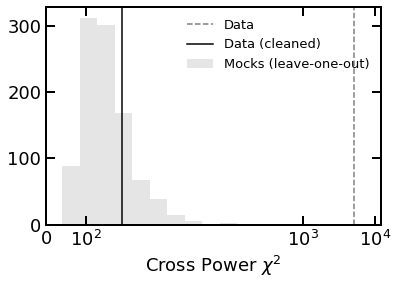

In [139]:
plt.hist(chi2_mocks, alpha=0.1, label='Mocks (leave-one-out)')
plt.axvline(chi2_before, alpha=0.5, ls='--', label='Data')
plt.axvline(chi2_after, label='Data (cleaned)')
plt.legend()
plt.xlabel(r'Cross Power $\chi^{2}$')
plt.xscale('symlog', linscalex=3, linthreshx=600.)
plt.xlim(0, 1.2e4)
# xaxis = plt.gca().xaSxis

# xaxis.set_ticks([i*200 for i in range(0, 4)]+[10**p for p in range(3, 5)])
# xaxis.set_major_locator(MajorSymLogLocator(linthresh=500.0, base=100.))
# xaxis.set_minor_locator(MinorSymLogLocator(600, nints=10))


# plt.xlim(xmax=1.1e4)
# plt.xticks([0, 100, 200, 300, 400, 500, 1000, 2000, 3000])
# plt.gca().xaxis.set_major_formatter(FormatStrFormatter("%e"))



In [4]:
err_min, err_max = np.percentile(err_tot, [15, 85], axis=0)

In [5]:
print(np.percentile(covmax, [1, 99]))

[-4.10708846e-15  3.13802444e-14]


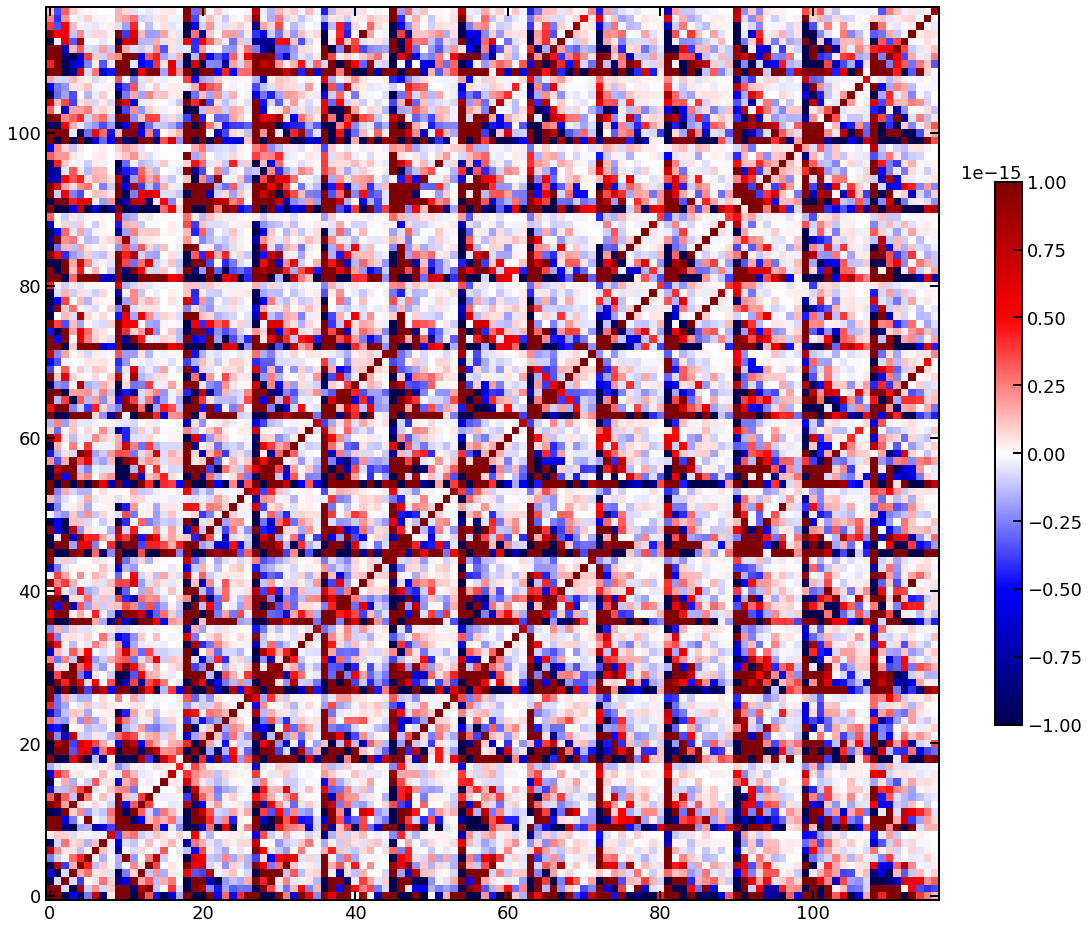

In [9]:
plt.figure(figsize=(20, 20))
plt.imshow(covmax, origin='lower', cmap=plt.cm.seismic, vmin=-1.0e-15, vmax=1.0e-15)
plt.colorbar(shrink=0.5)

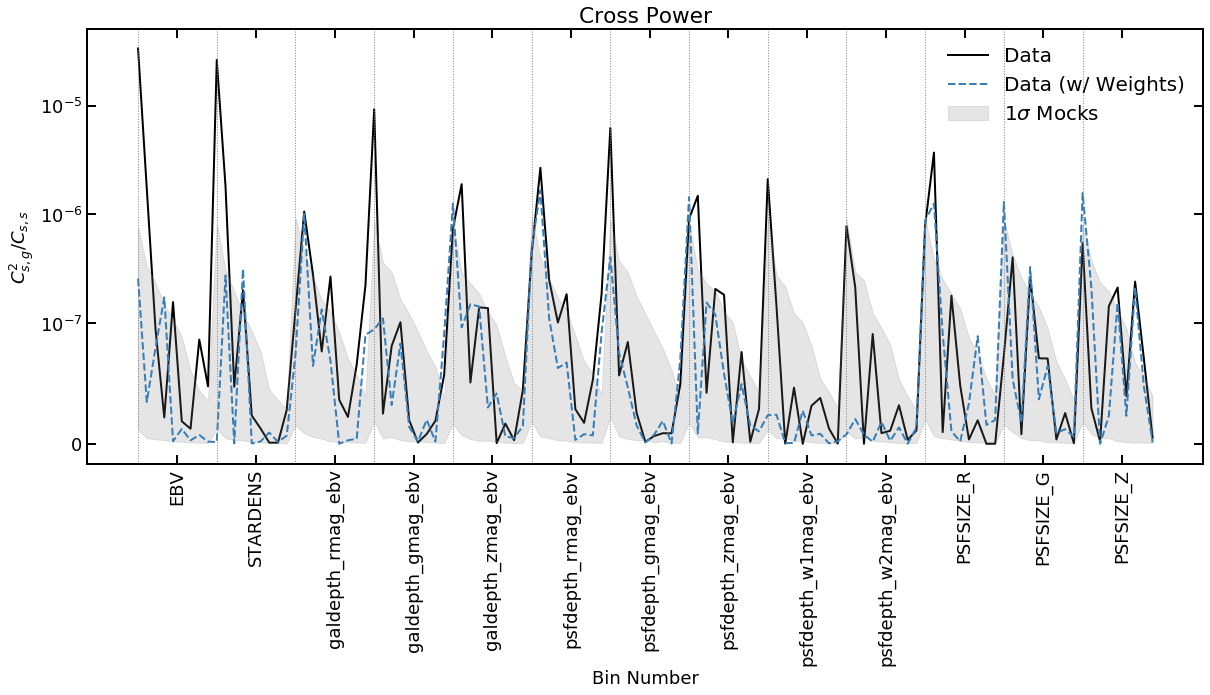

In [140]:
plt.figure(figsize=(20, 8))

plt.plot(err_0, color='C0', label='Data', lw=2, zorder=-1)
plt.plot(err_1, color='C1', ls='--', label='Data (w/ Weights)', lw=2)#, marker='o', mfc='w')
plt.fill_between(np.arange(err_min.size), err_min, err_max, color='grey', alpha=0.2, 
                label=r'$1\sigma$ Mocks')

plt.xlabel('Bin Number')
plt.ylabel(r'$C^2_{s,g}/C_{s,s}$')
plt.title('Cross Power')
plt.legend(fontsize=20)

binw = err_0.size / 13
_=plt.xticks([(i+0.5)*binw for i in range(13)], labels=maps_dr9, rotation=90)
for i in range(13):
    plt.axvline(i*binw, ls=':', color='grey', lw=1)
# plt.ylim(-0.02, 0.02)
plt.yscale('symlog', linthreshy=1.0e-7)
# plt.yscale('log')#, linthreshy=1.0e-6)

region: bmzls
..........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

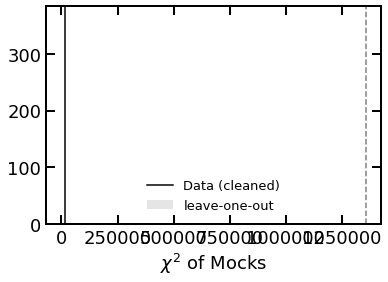

In [4]:
make_chi2plot('bmzls')

## Redshift Distribution

Text(0.5, 0, 'redshift')

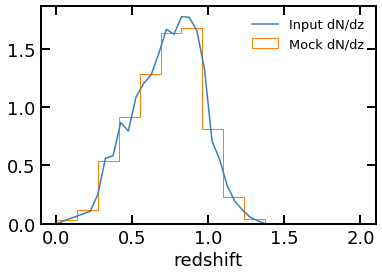

In [5]:
input_nz = np.loadtxt('/home/mehdi/github/flask/data/desi-z-selection-f1.dat')
catalog = ft.read('/home/mehdi/data/lognormal/lrg-cat-100.fits')
np.diff(input_nz[:, 0])

plt.plot(input_nz[:, 0], input_nz[:, 1]/(input_nz[:, 1].sum()*0.05), label='Input dN/dz')
plt.hist(catalog['z'], histtype='step', density=True, label='Mock dN/dz')

plt.legend()
plt.xlabel('redshift')

In [3]:
den_field = hp.read_map('/home/mehdi/data/lognormal/v0/lrg-88-f1z1.fits', verbose=False)

nside = 256


# nbar_sqdeg = 800. # per sq. deg
# nbar_sr = nbar_sqdeg * (180./np.pi)**(2)
# noise = 1./nbar_sr
# noise

den_contrast = den_field/den_field.mean() - 1.0
cl_obs = hp.anafast(den_contrast)
noise = hp.nside2pixarea(nside)/den_field.mean()
noise

5.247718593589074e-07

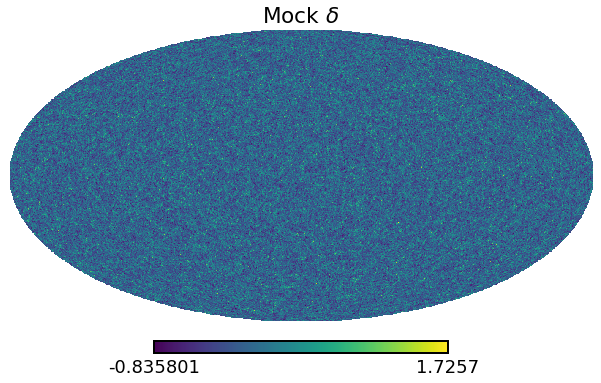

In [5]:
hp.mollview(den_contrast, title=r'Mock $\delta$')

Text(0.5, 0, 'Mock $\\delta$')

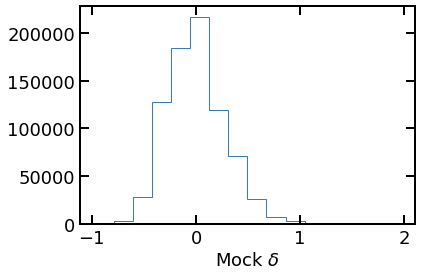

In [4]:
_ = plt.hist(den_contrast, histtype='step', bins=16)
plt.xlabel(r'Mock $\delta$')

## Power Spectra

In [3]:
cl_dr9 = np.load('/home/mehdi/data/rongpu/imaging_sys/clustering/v2/cl_lrg_bmzls_256_nn.npy', 
                allow_pickle=True).item()
cl_dr9n = np.load('/home/mehdi/data/rongpu/imaging_sys/clustering/v2/cl_lrg_bmzls_256_noweight.npy', 
                allow_pickle=True).item()
cl_model = np.loadtxt('/home/mehdi/github/flask/data/desiCl-f1z1f1z1.dat')

list_clmocks = glob('/home/mehdi/data/lognormal/v0/clustering/clmock_*_lrg_bmzls_256_noweight.npy')
print(len(list_clmocks))

cl_mocks = []

for fl in list_clmocks:
    cl_i = np.load(fl, allow_pickle=True).item()
    cl_mocks.append(cl_i['cl_gg']['cl'])
    print('.', end='')
    
cl_min, cl_max = np.percentile(cl_mocks, [15, 85], axis=0)
cl_mocks_mean = np.mean(cl_mocks, axis=0)

1000
...................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [4]:
# mask

dt = ft.read('/home/mehdi/data/rongpu/imaging_sys/tables/nlrg_features_bmzls_256.fits')
mask_ = make_hp(256, dt['hpix'], 1.0) > 0.5
mask = hp.ud_grade(mask_, 1024)
weight = mask * 1.0

noise = 5.247718593589074e-07
el_m = np.arange(2*1024)
wd = WindowSHT(weight, mask, el_m, ngauss=2*1024)
cl_model_noise = cl_model[:, 1]+noise
cl_model_wind_noise = wd.convolve(cl_model[:, 0], cl_model[:, 1])+noise

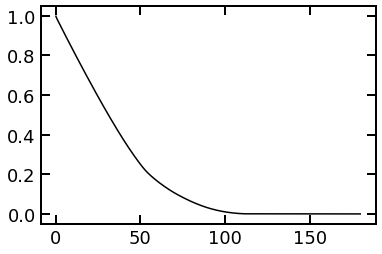

In [5]:
plt.plot(np.arccos(wd.x)*180./np.pi, wd.xi_mask)
# plt.xscale('log')
# plt.yscale('log')

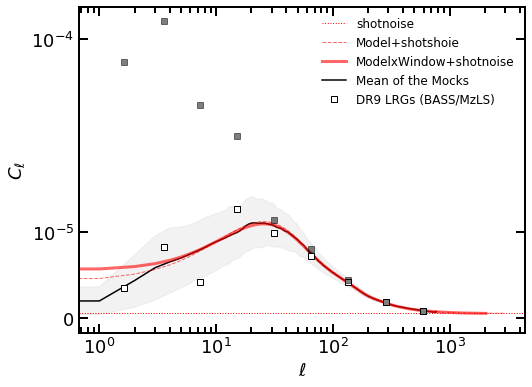

In [22]:
plt.figure(figsize=(8, 6))

# model
plt.axhline(noise, color='r', ls=':', lw=1, label='shotnoise')
plt.plot(cl_model_noise, 'r--', lw=1, alpha=0.6, label='Model+shotshoie')
plt.plot(cl_model_wind_noise, 'r-', lw=3, alpha=0.6, label='ModelxWindow+shotnoise')

# mocks
plt.plot(cl_mocks_mean, color='k', label='Mean of the Mocks', zorder=-1)
# for cl_mock_i in cl_mocks:
#     plt.plot(cl_mock_i, color='grey', lw=1, ls='-', alpha=0.02, zorder=-10)
plt.fill_between(np.arange(cl_min.size), cl_min, cl_max, alpha=0.1, color='grey', zorder=-10)


# data
plt.plot(*histogram_cell(cl_dr9['cl_gg']['cl'], bins=np.logspace(0, np.log10(769), 10)),
            marker='s', mfc='w', ls='None',
            color='k', label='DR9 LRGs (BASS/MzLS)')
plt.plot(*histogram_cell(cl_dr9n['cl_gg']['cl'], bins=np.logspace(0, np.log10(769), 10)),
            marker='s', color='k', alpha=0.5, ls='None')


plt.legend(fontsize=12) #, bbox_to_anchor=(1., 1.2))
# plt.ylim(1.0e-8, 1.0e-4)
plt.yscale('symlog', linthreshy=2.0e-5)
# plt.yticks([i*2.0e-6 for i in range(8)], labels=[f'{2*i}' for i in range(8)])
plt.ylabel(r'$C_{\ell}$')
plt.xlabel(r'$\ell$')
plt.xscale('log')

In [6]:
lbins = np.arange(1, 769, 50)
l_obs, cl_obs = histogram_cell(cl_dr9['cl_gg']['cl'], bins=lbins)


cl_mb = []

for cl_i in cl_mocks:
    cl_ib = histogram_cell(cl_i, bins=lbins)[1] 
    cl_mb.append(cl_ib)

clb_min, clb_max = np.percentile(cl_mb, [15, 85], axis=0)
clb_mean = np.mean(cl_mb, axis=0)

clb_model = histogram_cell(cl_model_wind_noise, bins=lbins)[1]

(0.5, 1.5)

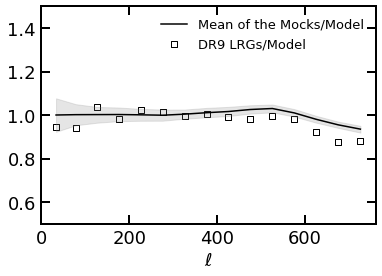

In [8]:
plt.scatter(l_obs, cl_obs/clb_model, marker='s', facecolor='w', 
            color='k', label='DR9 LRGs/Model')
plt.plot(l_obs, clb_mean/clb_model, color='k', label='Mean of the Mocks/Model')

plt.fill_between(l_obs, clb_min/clb_model, clb_max/clb_model, alpha=0.2, color='grey')

plt.legend()
plt.xlabel(r'$\ell$')
plt.ylim(0.5, 1.5)

In [58]:
lbins = np.arange(200, 601, 50)
l_obs, cl_obs = histogram_cell(cl_dr9['cl_gg']['cl'], bins=lbins)


cl_mb = []

for cl_i in cl_mocks:
    cl_ib = histogram_cell(cl_i, bins=lbins)[1] 
    cl_mb.append(cl_ib)

clb_mean = np.mean(cl_mb, axis=0)
clb_model = histogram_cell(cl_model_wind_noise, bins=lbins)[1]

clcov = np.cov(cl_mb, rowvar=False)
invcov = np.linalg.inv(clcov)

In [59]:
chi2_fn(cl_obs-clb_mean, invcov)

14.923096395131921

In [66]:
alphas = []
chi2_list = []
for beta in np.linspace(-0.06, 0.025):
    alpha = 1.0+beta
    alphas.append(alpha)
    chi2_list.append(chi2_fn(cl_obs-alpha*clb_mean, invcov))

In [68]:
invcov.shape

(8, 8)

Text(0, 0.5, '$\\chi^{2}$')

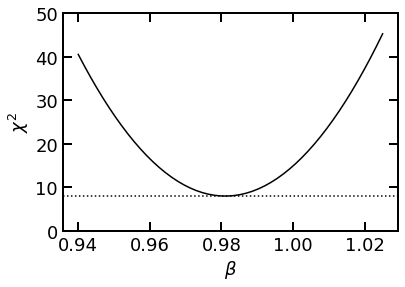

In [70]:
plt.plot(alphas, chi2_list)
plt.axhline(8.0, ls=':')
plt.ylim(0, 50)
plt.xlabel(r'$\beta$')
plt.ylabel(r'$\chi^{2}$')

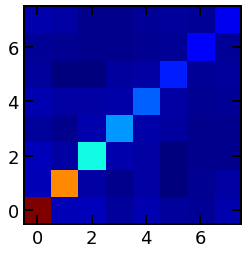

In [42]:
# chi-2
vmin, vmax = np.percentile(clcov, [1, 99])
plt.imshow(clcov, origin='lower', cmap=plt.cm.jet, vmin=vmin, vmax=vmax)

## Mean Density

In [3]:
def make_chi2plot(region):
    
    print(f'region: {region}')

    list_nbars = glob(f'/home/mehdi/data/lognormal/v0/clustering/nbarmock_*_lrg_{region}_256_noweight.npy')
    
    err_mat = read_nbmocks(list_nbars)
    err_0 = read_nnbar(f'/home/mehdi/data/rongpu/imaging_sys/clustering/v2/nbar_lrg_{region}_256_noweight.npy')
    err_1 = read_nnbar(f'/home/mehdi/data/rongpu/imaging_sys/clustering/v2/nbar_lrg_{region}_256_nn.npy')
    err_2 = read_nnbar(f'/home/mehdi/data/rongpu/imaging_sys/clustering/v2/nbar_lrg_{region}_256_nn.npy')

    
    print('# mocks', len(list_nbars))
    invcov, covmax = get_inv(err_mat, True)
    
    chi2_mocks = get_chi2pdf(err_mat)
    chi2_before = chi2_fn(err_0, invcov)
    chi2_after = chi2_fn(err_1, invcov)
    
    print(chi2_before, chi2_after)
    plt.hist(chi2_mocks, alpha=0.1, label='leave-one-out')
    plt.axvline(chi2_before, alpha=0.5, ls='--')
    plt.axvline(chi2_after, label='Data (cleaned)')
    plt.legend()
    plt.xlabel(r'$\chi^{2}$ of Mocks')
    plt.show()
    

#     fg, ax = plt.subplots(ncols=3, figsize=(12, 6), sharey=True)
#     fg.subplots_adjust(wspace=0.05, hspace=0.0)

#     map0 = ax[0].imshow(covmax, origin='lower', cmap=plt.cm.bwr, vmin=-2.0e-5, vmax=2.0e-5)
#     fg.colorbar(map0, ax=ax[0], orientation='horizontal', ticks=[-1.0e-5, 0, 1.0e-5], shrink=0.5)

#     map1 = ax[1].imshow(invcov, origin='lower', cmap=plt.cm.bwr, vmin=-2.0e6, vmax=2.0e6,)
#     fg.colorbar(map1, ax=ax[1], orientation='horizontal', shrink=0.5, ticks=[-1.0e6, 0, 1.0e6])


#     map2 = ax[2].imshow(covmax.dot(invcov), origin='lower', cmap=plt.cm.viridis, vmin=0, vmax=2.0)
#     fg.colorbar(map2, ax=ax[2], orientation='horizontal', ticks=[0., 1, 2.0], shrink=0.5)
#     plt.show()

region: bmzls
..........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

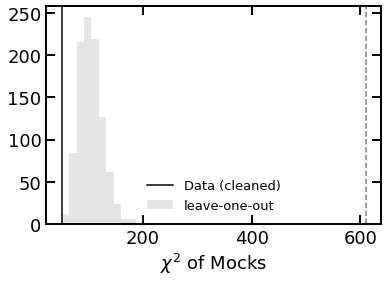

In [4]:
make_chi2plot('bmzls')

region: bmzls
..........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

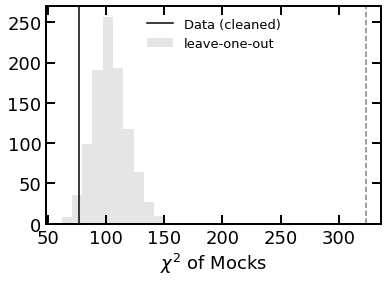

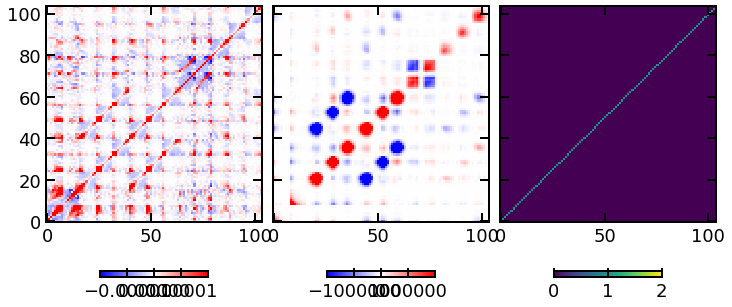

In [13]:
make_chi2plot('bmzls')

region: ndecals
........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

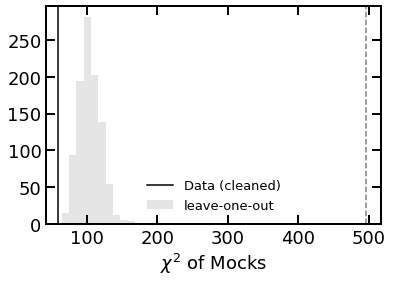

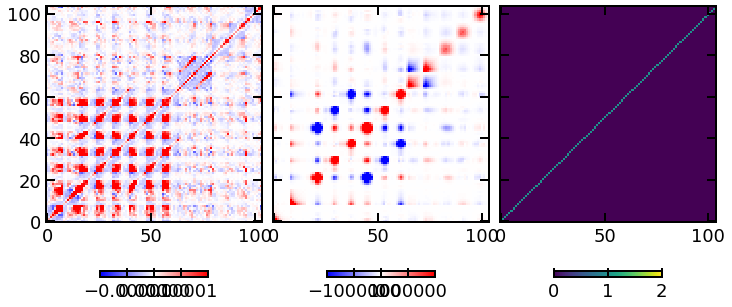

In [14]:
make_chi2plot('ndecals')

region: sdecals
........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

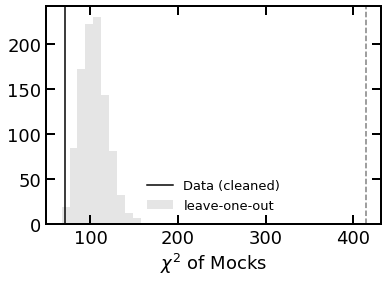

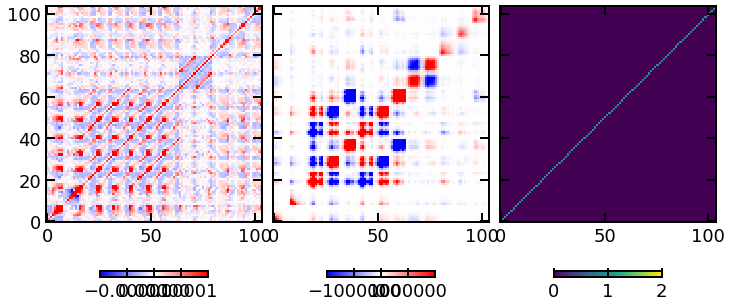

In [15]:
make_chi2plot('sdecals')

In [16]:
region = 'bmzls'
print(f'region: {region}')

list_nbars = glob(f'/home/mehdi/data/lognormal/v0/clustering/nbarmock_*_lrg_{region}_256_noweight.npy')
err_mat = read_nbmocks(list_nbars)
err_0 = read_nnbar(f'/home/mehdi/data/rongpu/imaging_sys/clustering/v2/nbar_lrg_{region}_256_noweight.npy')
err_1 = read_nnbar(f'/home/mehdi/data/rongpu/imaging_sys/clustering/v2/nbar_lrg_{region}_256_nn.npy')

print('# mocks', len(list_nbars))
invcov, covmax = get_inv(err_mat, True)

region: bmzls
..........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [18]:
err_min, err_max = np.percentile(err_mat, [15, 85], axis=0)

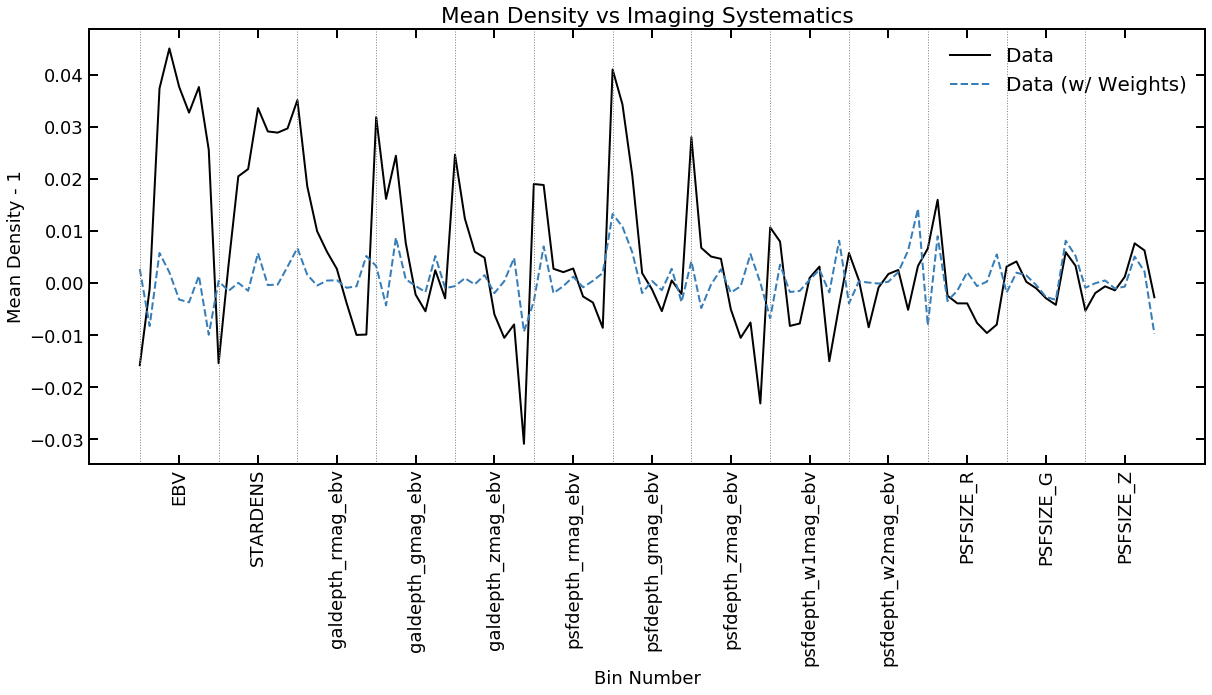

In [19]:
plt.figure(figsize=(20, 8))
plt.plot(err_0, color='C0', label='Data', lw=2, zorder=-1)
plt.plot(err_1, color='C1', ls='--', label='Data (w/ Weights)', lw=2)

#for err_mi in err_mat:
#    plt.plot(err_mi, color='C1', alpha=0.1, zorder=-2)
# plt.fill_between(np.arange(err_min.size), err_min, err_max, color='C1', alpha=0.2)

plt.xlabel('Bin Number')
plt.ylabel('Mean Density - 1')
plt.title('Mean Density vs Imaging Systematics')
plt.legend(fontsize=20)
_=plt.xticks([i*8+4 for i in range(13)], labels=maps_dr9, rotation=90)
for i in range(13):
    plt.axvline(i*8, ls=':', color='grey', lw=1)
# plt.ylim(-0.02, 0.02)

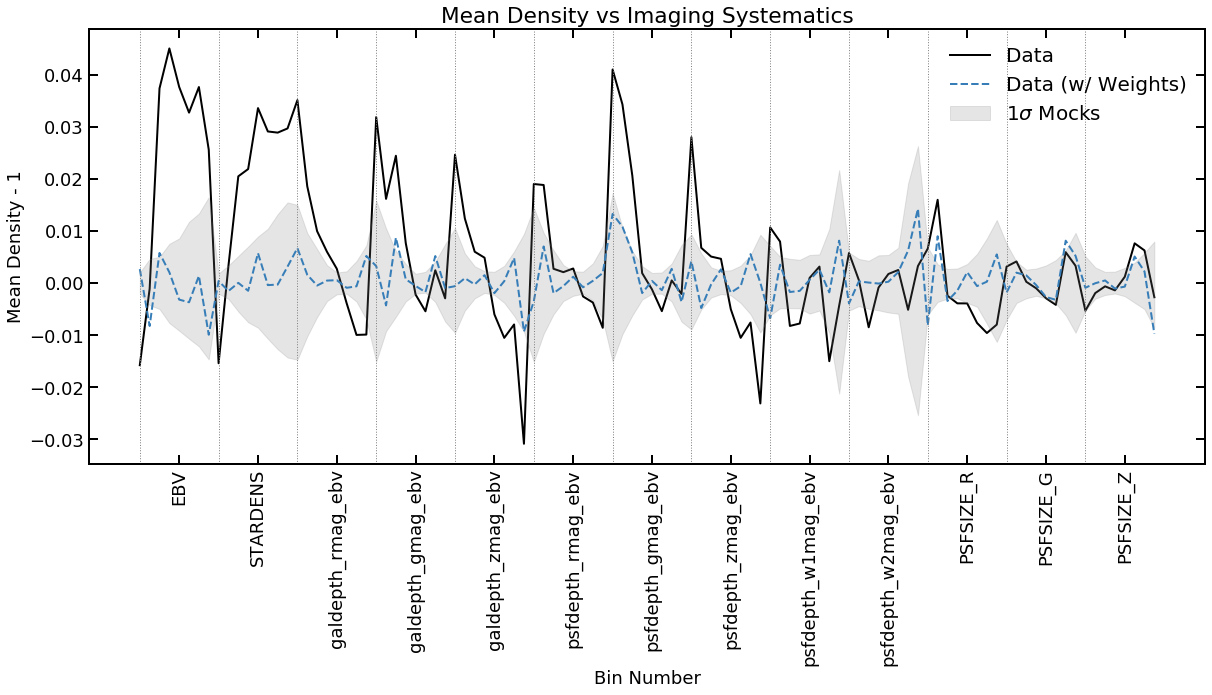

In [22]:
plt.figure(figsize=(20, 8))
plt.plot(err_0, color='C0', label='Data', lw=2, zorder=-1)
plt.plot(err_1, color='C1', ls='--', label='Data (w/ Weights)', lw=2)

#for err_mi in err_mat:
#    plt.plot(err_mi, color='C1', alpha=0.1, zorder=-2)
plt.fill_between(np.arange(err_min.size), err_min, err_max, color='grey', alpha=0.2, 
                label=r'$1\sigma$ Mocks')

plt.xlabel('Bin Number')
plt.ylabel('Mean Density - 1')
plt.title('Mean Density vs Imaging Systematics')
plt.legend(fontsize=20)
_=plt.xticks([i*8+4 for i in range(13)], labels=maps_dr9, rotation=90)
for i in range(13):
    plt.axvline(i*8, ls=':', color='grey', lw=1)
# plt.ylim(-0.02, 0.02)

In [92]:
err_scale = err_mat - err_mat.mean(axis=0)

In [95]:
covs = np.cov(err_scale, rowvar=False)

In [96]:
invcovs = np.linalg.inv(covs)

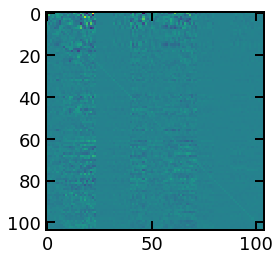

In [98]:
plt.imshow(covs.dot(invcovs))

In [36]:
d0 = np.load(list_nbars[0], allow_pickle=True)
d1 = np.load(list_nbars[10], allow_pickle=True)

In [37]:
d0[0]

{'nnbar': array([0.99585615, 1.00197567, 0.99586151, 1.00315507, 1.00664504,
        0.9914709 , 1.00287094, 1.00216488]),
 'area': array([12222., 12222., 12222., 12222., 12222., 12222., 12222., 12221.]),
 'nnbar_err': array([0.00296832, 0.00223668, 0.00280899, 0.00262396, 0.00251104,
        0.00167031, 0.00294963, 0.00239442]),
 'bin_edges': array([0.00367896, 0.01166427, 0.01457686, 0.01783316, 0.02281092,
        0.03234769, 0.04577622, 0.06690618, 0.41883251]),
 'bin_avg': array([0.00951587, 0.01314601, 0.01615297, 0.02008719, 0.02713269,
        0.03881256, 0.05500321, 0.10328343]),
 'attr': {'njack': 20, 'nbar': 30.524377397085143, 'npix2area': 1.0},
 'sys': 'EBV'}

In [38]:
d1[0]

{'nnbar': array([0.99679299, 1.00678415, 0.99902492, 0.99694914, 1.00104684,
        1.00213992, 0.9989253 , 0.9983366 ]),
 'area': array([12222., 12222., 12222., 12222., 12222., 12222., 12222., 12221.]),
 'nnbar_err': array([0.00309704, 0.00221506, 0.00235517, 0.00261592, 0.00255848,
        0.00312274, 0.002693  , 0.00330425]),
 'bin_edges': array([0.00367896, 0.01166427, 0.01457686, 0.01783316, 0.02281092,
        0.03234769, 0.04577622, 0.06690618, 0.41883251]),
 'bin_avg': array([0.00951587, 0.01314601, 0.01615297, 0.02008719, 0.02713269,
        0.03881256, 0.05500321, 0.10328343]),
 'attr': {'njack': 20, 'nbar': 30.390130401431858, 'npix2area': 1.0},
 'sys': 'EBV'}

In [100]:
dd = np.load('/home/mehdi/data/rongpu/imaging_sys/clustering/v2/nbar_lrg_bmzls_256_nn.npy', allow_pickle=True)
dd[0]

{'nnbar': array([0.99375002, 1.00171952, 1.00407873, 1.00527443, 0.99580699,
        0.9939571 , 1.00634445, 0.99906858]),
 'area': array([12221.93515835, 12222.77626307, 12222.22381377, 12221.98880691,
        12222.91208552, 12222.19999904, 12222.26856452, 12218.69530881]),
 'nnbar_err': array([0.00400074, 0.0025467 , 0.00222308, 0.00226435, 0.00331056,
        0.00136965, 0.00253457, 0.00172797]),
 'bin_edges': array([0.00367896, 0.01155863, 0.01439689, 0.01749723, 0.02209954,
        0.03091424, 0.04398893, 0.06449677, 0.41883251]),
 'bin_avg': array([0.00943713, 0.01300348, 0.01589296, 0.01956954, 0.0260189 ,
        0.03723095, 0.05299107, 0.0991519 ]),
 'attr': {'njack': 20,
  'nbar': 1.0003323740528882,
  'npix2area': 1.0982169373903181},
 'sys': 'EBV'}

In [33]:
maps_dr9 = ['EBV', 'STARDENS']\
          + [f'galdepth_{b}mag_ebv' for b in ['r', 'g', 'z']]\
          + [f'psfdepth_{b}mag_ebv' for b in ['r', 'g', 'z', 'w1', 'w2']] \
          + [f'PSFSIZE_{b}' for b in ['R', 'G', 'Z']]
for i, mapi in enumerate(maps_dr9):
    print(i, mapi)

0 EBV
1 STARDENS
2 galdepth_rmag_ebv
3 galdepth_gmag_ebv
4 galdepth_zmag_ebv
5 psfdepth_rmag_ebv
6 psfdepth_gmag_ebv
7 psfdepth_zmag_ebv
8 psfdepth_w1mag_ebv
9 psfdepth_w2mag_ebv
10 PSFSIZE_R
11 PSFSIZE_G
12 PSFSIZE_Z


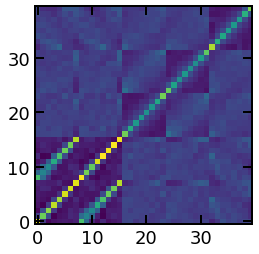

In [27]:
plt.imshow(covmax[8*8:,8*8:], origin='lower')

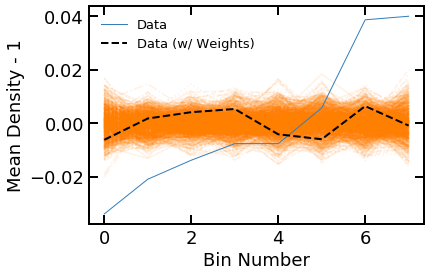

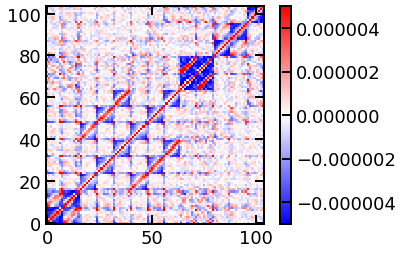

In [7]:
plt.imshow(errcov*hartlapf, origin='lower', 
           cmap=plt.cm.bwr, vmin=-5.0e-6, vmax=5.0e-6)
plt.colorbar()

8.0

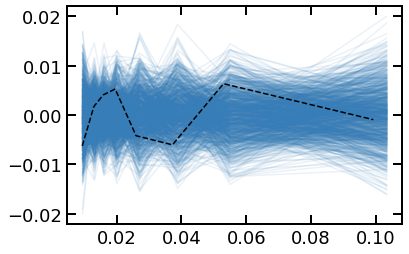

In [101]:
for nbar_i in list_nbars:
    d_i = np.load(nbar_i, allow_pickle=True)[0]
    
    plt.plot(d_i['bin_avg'], d_i['nnbar']-1, ls='-', color='C0', alpha=0.1)    
    
plt.plot(dd[0]['bin_avg'], dd[0]['nnbar']-1, 'k--')

In [ ]:
#---- Next

# create ensemble of full sky log-normal mocks
# check if the observed data cell agrees with the mock dispersion on high-ell (ell > 20)?
# split into BASS / DECaLS North / DECaLS South
# measure C_ell, mean density, etc 
# construct covariance matrices
# test for remaining systematics,
# create non-zero fNL mocks, something close to yield the observed C_ell after mitigation


# keep in mind
# look at the nbar after the mitigation
# make sure high ell of the data matches that of the input model to FLASK
# adjust the maximum volume density